# **Imports Libraries**

---



In [68]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split

# **Import Dataset**

---



In [2]:
!gdown --id '15FMORg3CWXch-05PIXwApvOZ_aa8iLjM'

Downloading...
From: https://drive.google.com/uc?id=15FMORg3CWXch-05PIXwApvOZ_aa8iLjM
To: /content/Dataset_1.csv
100% 999k/999k [00:00<00:00, 45.9MB/s]


In [26]:
data=pd.read_csv("Dataset_1.csv", encoding = "ISO-8859-1")
data.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [27]:
data["length"]=data["message"].apply(len)

In [28]:
data.head(5)

,message,label,length
0,just had a real good moment. i missssssssss hi...,0,57
1,is reading manga http://plurk.com/p/mzp1e,0,42
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,84
3,@lapcat Need to send 'em to my accountant tomo...,0,135
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,45


In [29]:
data.isnull().sum()

message    0
label      0
length     0
dtype: int64

In [30]:
data['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

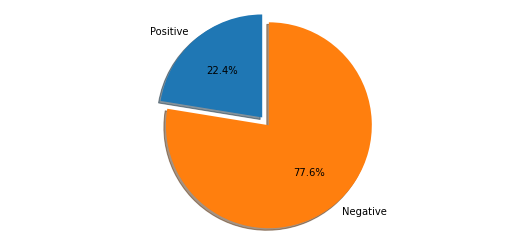

In [31]:
labels = 'Positive', 'Negative'
sizes = [2314, 8000]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

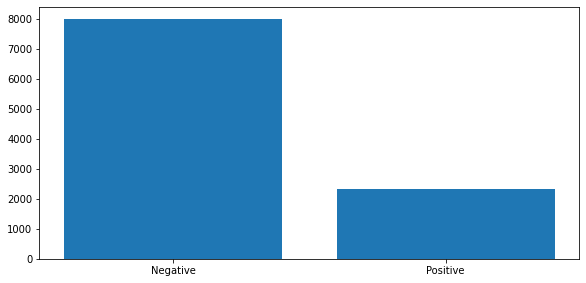

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Label = ['Negative', 'Positive']
students = np.array(data['label'].value_counts())
ax.bar(Label,students)
plt.show()

# **Data Preprocessing**



In [33]:
nltk.download('stopwords')
stop=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [35]:
def stop_words(df):
    df['stopwords'] = df['message'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['message','stopwords']].head(10))

In [36]:
stop_words(data)

                                             message  stopwords
0  just had a real good moment. i missssssssss hi...          6
1         is reading manga  http://plurk.com/p/mzp1e          1
2  @comeagainjen http://twitpic.com/2y2lx - http:...          0
3  @lapcat Need to send 'em to my accountant tomo...          7
4      ADD ME ON MYSPACE!!!  myspace.com/LookThunder          0
5              so sleepy. good times tonight though           1
6  @SilkCharm re: #nbn as someone already said, d...         10
7              23 or 24Ã¯Â¿Â½C possible today. Nice           1
8        nite twitterville  workout in the am  -ciao          3
9    @daNanner Night, darlin'!  Sweet dreams to you           2


## removing (http, .com , @,re:) from text

In [37]:
def webAddressRemove(df):  
    df['message'] = df['message'].apply(lambda x: " ".join(x for x in x.split() if (x[0] != '@') & ('http' not in x)& ('.com' not in x) & ('re:' not in x)))
    print(df['message'].head(10))

In [38]:
webAddressRemove(data)

0    just had a real good moment. i missssssssss hi...
1                                     is reading manga
2                                                    -
3    Need to send 'em to my accountant tomorrow. Od...
4                                 ADD ME ON MYSPACE!!!
5                 so sleepy. good times tonight though
6    #nbn as someone already said, does fiber to th...
7                 23 or 24Ã¯Â¿Â½C possible today. Nice
8            nite twitterville workout in the am -ciao
9                  Night, darlin'! Sweet dreams to you
Name: message, dtype: object


In [39]:
data.isnull().sum()

message      0
label        0
length       0
stopwords    0
dtype: int64

## **Removing punctuation**

In [40]:
def RemovePunctuation(df):
    df['message'] = df['message'].str.replace('[^\w\s]','')
    print(df['message'].head())

In [41]:
RemovePunctuation(data)

0    just had a real good moment i missssssssss him...
1                                     is reading manga
2                                                     
3    Need to send em to my accountant tomorrow Oddl...
4                                    ADD ME ON MYSPACE
Name: message, dtype: object


## **Remove most frequent words**

In [42]:
freq = pd.Series(' '.join(data['message']).split()).value_counts()[:15]
freq

to            3758
the           3448
a             2949
I             2839
and           2574
you           2143
depression    1807
of            1778
my            1705
is            1659
for           1594
in            1459
it            1453
i             1174
with          1103
dtype: int64

In [43]:
freq = list(freq.index)
freq

['to',
 'the',
 'a',
 'I',
 'and',
 'you',
 'depression',
 'of',
 'my',
 'is',
 'for',
 'in',
 'it',
 'i',
 'with']

In [44]:
freq.remove('to')
freq.remove('the')
freq

['a',
 'I',
 'and',
 'you',
 'depression',
 'of',
 'my',
 'is',
 'for',
 'in',
 'it',
 'i',
 'with']

In [45]:
#Removing the most frequent words from the dataset
def frequent_words_removal(df):  
    df['message'] = df['message'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['message'].head(10))

In [46]:
frequent_words_removal(data)

0    just had real good moment missssssssss him so ...
1                                        reading manga
2                                                     
3    Need to send em to accountant tomorrow Oddly w...
4                                    ADD ME ON MYSPACE
5                  so sleepy good times tonight though
6    nbn as someone already said does fiber to the ...
7                    23 or 24ÃÂÂ½C possible today Nice
8                nite twitterville workout the am ciao
9                         Night darlin Sweet dreams to
Name: message, dtype: object


## **Removing Rare words**

In [51]:
freq = pd.Series(' '.join(data['message']).split()).value_counts()[-15:]
freq

Tweeple               1
handmade              1
goofin                1
accomplishment        1
skitch                1
Basketball            1
grieving              1
attacking             1
Taiwan                1
Canarywharf           1
Coalesce              1
RUN                   1
wordÃÂÂ½tweetheart    1
IRL                   1
unknown               1
dtype: int64

In [52]:
freq = list(freq.index)
def Remove_Rare(df):
    df['message'] = df['message'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['message'].head(10))

In [53]:
Remove_Rare(data)

0    just had real good moment missssssssss him so ...
1                                        reading manga
2                                                     
3    Need to send em to accountant tomorrow Oddly w...
4                                    ADD ME ON MYSPACE
5                  so sleepy good times tonight though
6    nbn as someone already said does fiber to the ...
7                    23 or 24ÃÂÂ½C possible today Nice
8                nite twitterville workout the am ciao
9                         Night darlin Sweet dreams to
Name: message, dtype: object


In [54]:
stop_words(data)

                                             message  stopwords
0  just had real good moment missssssssss him so ...          4
1                                      reading manga          0
2                                                             0
3  Need to send em to accountant tomorrow Oddly w...          4
4                                  ADD ME ON MYSPACE          0
5                so sleepy good times tonight though          1
6  nbn as someone already said does fiber to the ...         10
7                  23 or 24ÃÂÂ½C possible today Nice          1
8              nite twitterville workout the am ciao          2
9                       Night darlin Sweet dreams to          1


## **Stemming and Removing Stopwords**

In [55]:
stemmer=PorterStemmer()

In [58]:
corpus=[]
for i in range(len(data)):
    #replacing everything other than alphabets with a space
    message=re.sub("[^a-zA-Z]"," ",str(data["message"][i]))
    #Lowering the tweets
    message=message.lower()
    #Converting in a list
    message=message.split()
    #Finding and removing stopwords
    message=[stemmer.stem(word) for word in message if not word in set(stopwords.words("english"))]
    #Joining after removal of stopwords
    message=" ".join(message)
    corpus.append(message)

In [59]:
corpus

['real good moment missssssssss much',
 'read manga',
 '',
 'need send em account tomorrow oddli wasnt even refer tax support evid though',
 'add myspac',
 'sleepi good time tonight though',
 'nbn someon alreadi said fiber home mean least regular',
 'c possibl today nice',
 'nite twittervil workout ciao',
 'night darlin sweet dream',
 'good morn everybodi',
 'final creat wordpress blog there alreadi blog seattl coffe commun',
 'kisha cnt get u til get frm u rememb ur top',
 'ye rememb band awesom pleas repli',
 'realli love reflect shadow',
 'ooo fantasi like fantasi novel check',
 'prob sell noth blog ill get listen band itun',
 'quotnokla connect peoplequot',
 'stay late start earli good thing like job',
 'read new job congratul that fantast',
 'havent abl sleep think ill watch ugli betti onlin',
 'woo thank ron steev follow yeow folowerssss haha ps wanna got ellen show',
 'yeah sure sister take extra gd care',
 'yay duck want anyth watch itd duck lol',
 'smaaack ass hahhahahaa make 

## **Creating TFIDF**

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv=TfidfVectorizer()
X=tfv.fit_transform(corpus).toarray()
y=data["label"]

## **Splitting Dataset**

In [64]:
vocab_size = 6000

#one hot encoding
one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

#length of all rows should be equal therefore applying padding this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

array([[   0,    0,    0, ..., 4342, 4930, 5003],
       [   0,    0,    0, ...,    0, 2022,  860],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 3641, 1878, 4057],
       [   0,    0,    0, ..., 4558, 2950, 5939],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [65]:
X = np.array(embedded_layer)
y = np.array(y)

In [67]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [69]:
X_train.shape,y_train.shape

((8251, 50), (8251,))

In [70]:
X_test.shape,y_test.shape

((2063, 50), (2063,))

# **Model**

---

In [81]:
embed_vec_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embed_vec_length,input_length = len(X_train[0])))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 32)            192000    
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 50, 128)           20608     
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 50, 128)           32896     
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 278,529
Trainable params: 278,529
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 10, batch_size = 100)

Epoch 1/10
83/83 [==============================] - 17s 176ms/step - loss: 0.5216 - accuracy: 0.7738 - val_loss: 0.4627 - val_accuracy: 0.8148
Epoch 2/10
83/83 [==============================] - 16s 193ms/step - loss: 0.3348 - accuracy: 0.8726 - val_loss: 0.2676 - val_accuracy: 0.8948
Epoch 3/10
83/83 [==============================] - 16s 192ms/step - loss: 0.1337 - accuracy: 0.9525 - val_loss: 0.2885 - val_accuracy: 0.9050
Epoch 4/10
83/83 [==============================] - 16s 189ms/step - loss: 0.0542 - accuracy: 0.9816 - val_loss: 0.3856 - val_accuracy: 0.8827
Epoch 5/10
83/83 [==============================] - 13s 158ms/step - loss: 0.0252 - accuracy: 0.9913 - val_loss: 0.4328 - val_accuracy: 0.8871
Epoch 6/10
83/83 [==============================] - 14s 173ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.4881 - val_accuracy: 0.8919
Epoch 7/10
83/83 [==============================] - 15s 185ms/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.5351 - val_accuracy: 0.8774

In [83]:
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [84]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

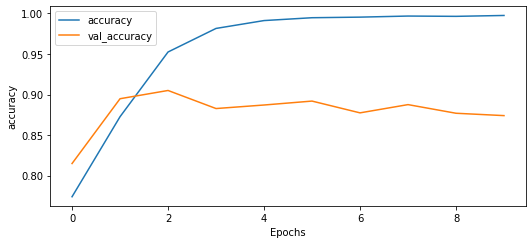

In [85]:
plot_graphs(history, "accuracy")

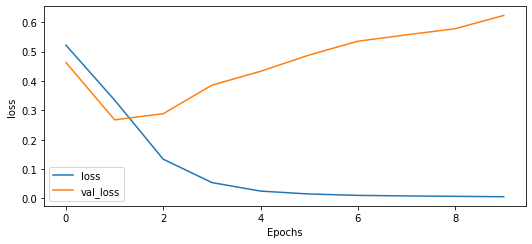

In [86]:
plot_graphs(history, "loss")

In [87]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [88]:
len(y_pred)

2063

In [96]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1445,  128],
       [ 132,  358]])

In [97]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [124]:
import tensorflow as tf
def predict_message(text):
  message=re.sub("[^a-zA-Z]"," ",str(text))
  #Lowering the tweets
  message=message.lower()
  #Converting in a list
  message=message.split()
  #Finding and removing stopwords
  message=[stemmer.stem(word) for word in message if not word in set(stopwords.words("english"))]
  #Joining after removal of stopwords
  message=" ".join(message)
  # print("here===",message)
  one_hot_dir = [one_hot(words,vocab_size) for words in [message]]

  #length of all rows should be equal therefore applying padding
  #this will adjust size by adding 0 at staring of the shorter rows
  embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
  
  embedded_layer = np.array(embedded_layer)
  output = model(embedded_layer)
  prediction = output.numpy()
  prediction = prediction[0][0]
  print(prediction)
  
  if prediction > 0.5:
    print(f'{prediction:0.3}: Positive')
    return 1
  else:
    print(f'{prediction:0.3}: Negative')
    return 0

In [111]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test,y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test,y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_pred)
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

Accuracy: 0.873970
Precision: 0.736626
Recall: 0.730612
F1 score: 0.733607
[[1445  128]
 [ 132  358]]


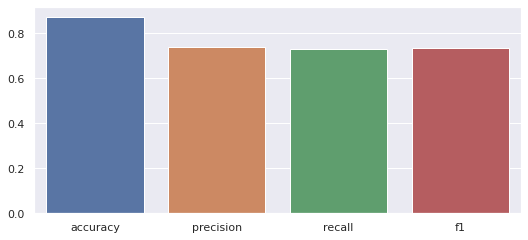

In [112]:
import seaborn as sns
sns.set()
scores = ['accuracy','precision','recall','f1']
values = [accuracy,precision,recall,f1]
sns.barplot(x=scores,y=values)

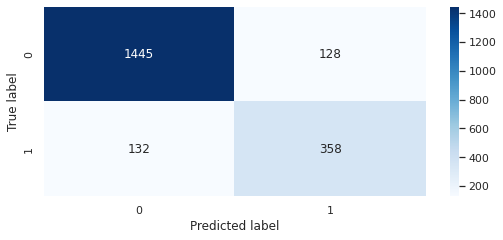

In [113]:
sns.heatmap(matrix, annot=True, fmt="d", cmap ="Blues") # font size
plt.xlabel("Predicted label") 
plt.ylabel("True label") 
plt.show()

# **Prediction**

---



In [122]:
test1 = "Excellent cast,story line and performance."
predict_message(test1)

0.736744
0.737: Positive


1

In [123]:
test2 = "The story itself is just predictable and lazy  http://plurk.com/p/vh81e"
predict_message(test2)

0.014713705
0.0147: Negative


0